## Module 4.3: Dense Networks - Dense Blocks and Transition Blocks

We will see how to create the basic building blocks for dense networks.

We will:

- Implement basic and condensing dense blocks of convolutional layers.
- Implement transition blocks.
- Create basic models and visually examine the residual architecture.

Since we are looking at layers/blocks of layers rather than networks, we will not solve a problem in this module. However it is a good exercise for you to try on your own to make use of these ideas to improve the CNN performance from module 2.2

We import the desired libraries.

In [0]:
from keras.models import Model
from keras.layers import Input,Conv2D,Flatten,Dense,Concatenate,MaxPool2D
from keras.utils import plot_model

We will start off with a basic dense block that will accumulate feature maps inside the block. As well as passing the input layer, we will specify the number of convolution layers and the number of filters (feature maps) each layer will generate.

You can off course allow the caller much more control of the internals of this function by using additional arguments.

In [0]:
def simple_dense_block (layer_in,n,filters):
  # Define first convolution layer
  prev_layer = Conv2D(filters, (3,3), padding='same', activation='relu')(layer_in)
    
  for f in range(1,n):
    # Define later convolution layers
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(prev_layer)
    # Define concatenation for skip connection (& update prev_layer)
    # This will accumulate feature maps
    prev_layer = Concatenate()([prev_layer, conv]) 
  
  return prev_layer
  

Here we design a simple network using such a dense block, and plot the network architecture.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 32) 18464       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_3[0][0]                   
____________________________________________________________________________________________

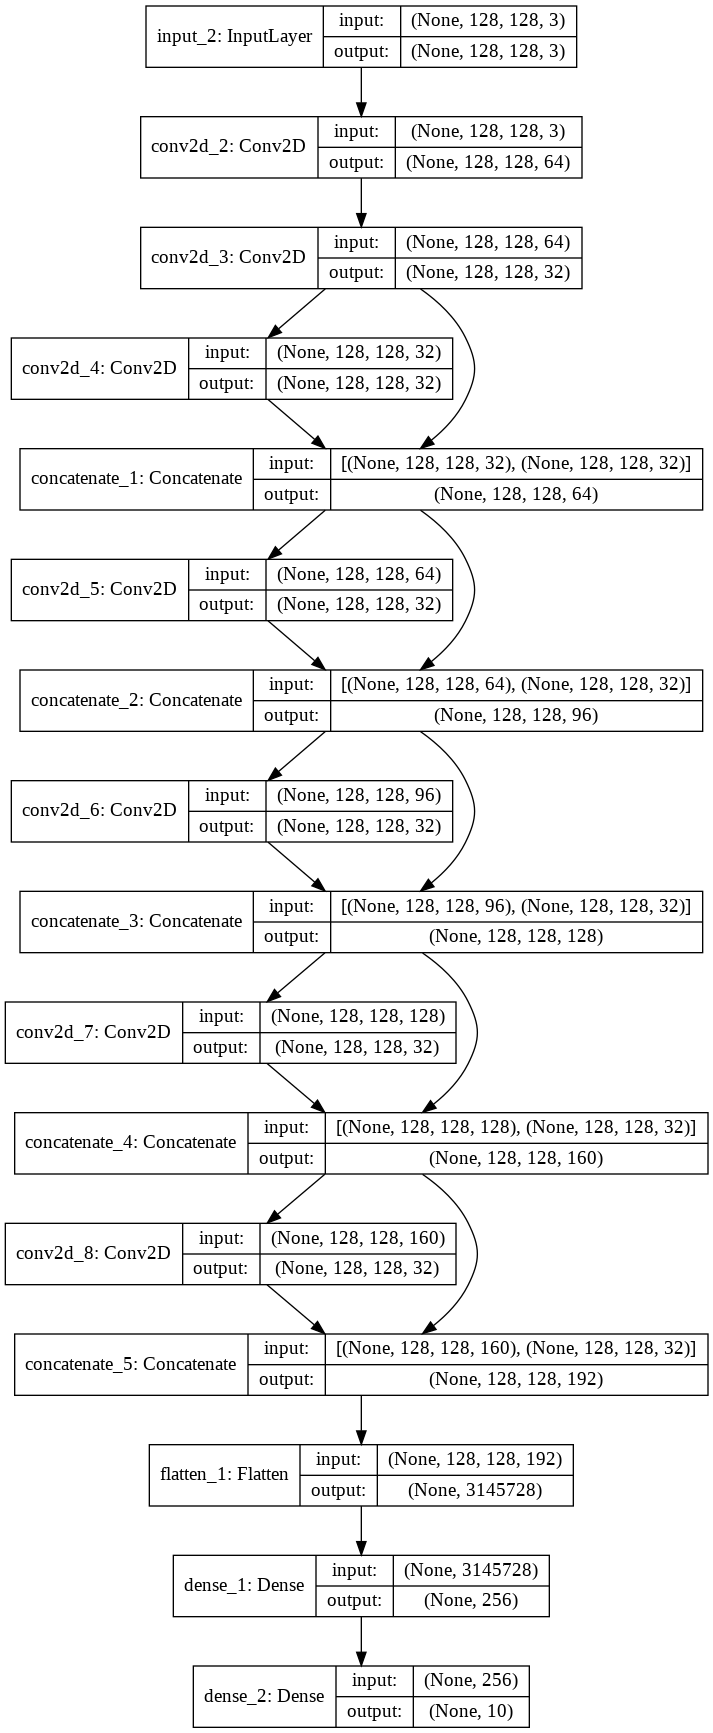

In [0]:
# Define input
inputs = Input(shape=(128, 128, 3))
# Initial convolution layer
conv = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)    
# Define dense block:
# 6 layers, each adding 32 feature maps
dense_block=simple_dense_block(conv,6,32)
# Flatten for output
flat = Flatten()(dense_block)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='dense_module.png')

Now let's add a 1x1 filter to compress the number of input channels each convolution layer is working with inside our dense block.

In [0]:
def condensed_dense_block (layer_in,n,filters,condense_size):
  # Define first 1x1 condensation layer plus convolution layer
  merged = Conv2D(condense_size,(1,1),activation='relu')(layer_in)
  prev_layer = Conv2D(filters, (3,3), padding='same', activation='relu')(merged)
    
  for f in range(1,n):
    # Define later 1x1 condensation layer plus convolution layer
    merged = Conv2D(condense_size,(1,1),activation='relu')(prev_layer)
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(merged)
    # Define concatenation for skip connection (& update prev_layer)
    # This will accumulate feature maps
    prev_layer = Concatenate()([prev_layer, conv]) 
  
  return prev_layer

And again we design a simple network using the new condensed_dense_block wrapper function so we can plot the network architecture.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 64) 4160        conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 18464       conv2d_11[0][0]                  
____________________________________________________________________________________________

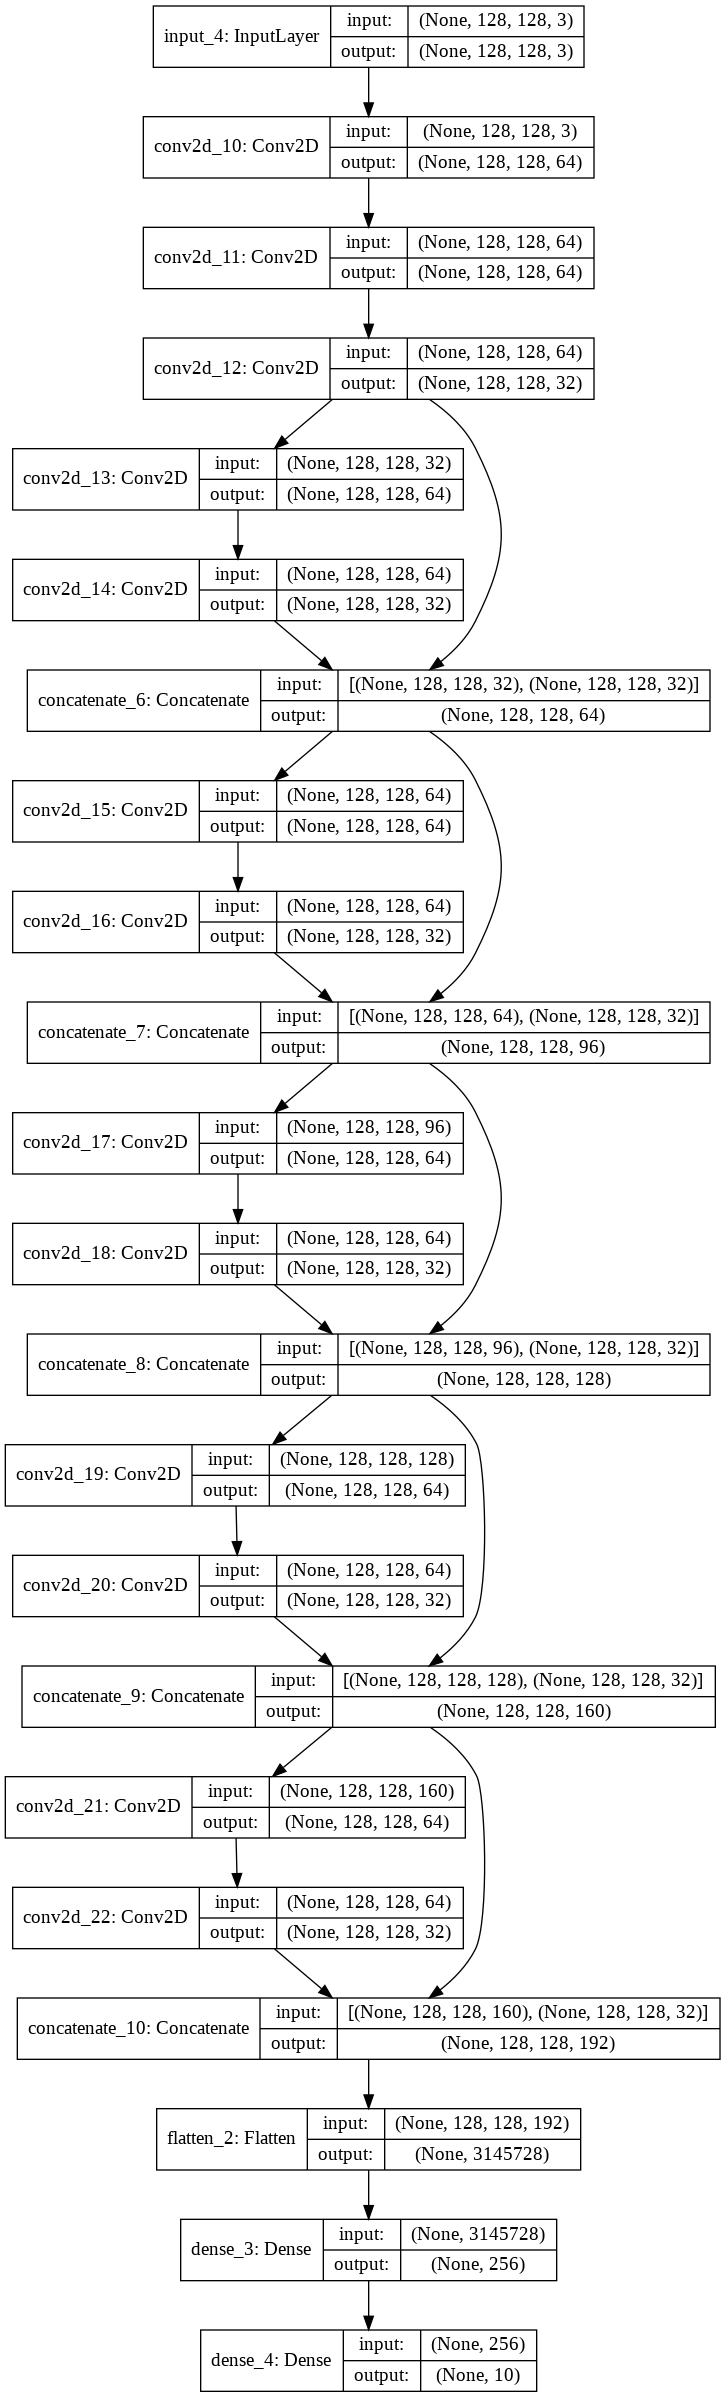

In [0]:
# Define input
inputs = Input(shape=(128, 128, 3))
# Initial convolution layer
conv = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)    
# Define dense block:
# 6 layers, each adding 32 feature maps
dense_block=condensed_dense_block(conv,6,32,64)
# Flatten for output
flat = Flatten()(dense_block)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='dense_module.png')

Finally we will create a wrapper function to make a transition layer that halves the number of channels using a 1x1 filter and halves the dimensionality of the matrices in each channel using a max pooling layer.

In [0]:
def transition_block (layer_in):
  # 1x1 filter halves channels
  ch_merged = Conv2D(conv._keras_shape[3],(1,1),activation='relu')(layer_in)
  # Max pooling with second argument (strides) as (2,2) halves matrix dimensionality 
  mt_merged = MaxPool2D((2, 2),(2,2))(ch_merged)
  return mt_merged

We create a simple network that has two (condensed) dense blocks separated by a transition block, and plot the architecture.

You can create a wrapper function to make a number of dense and transition blocks chained together. This is left as an exercise.

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 128, 128, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 128, 128, 64) 4160        conv2d_105[0][0]                 
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 128, 128, 32) 18464       conv2d_106[0][0]                 
____________________________________________________________________________________________

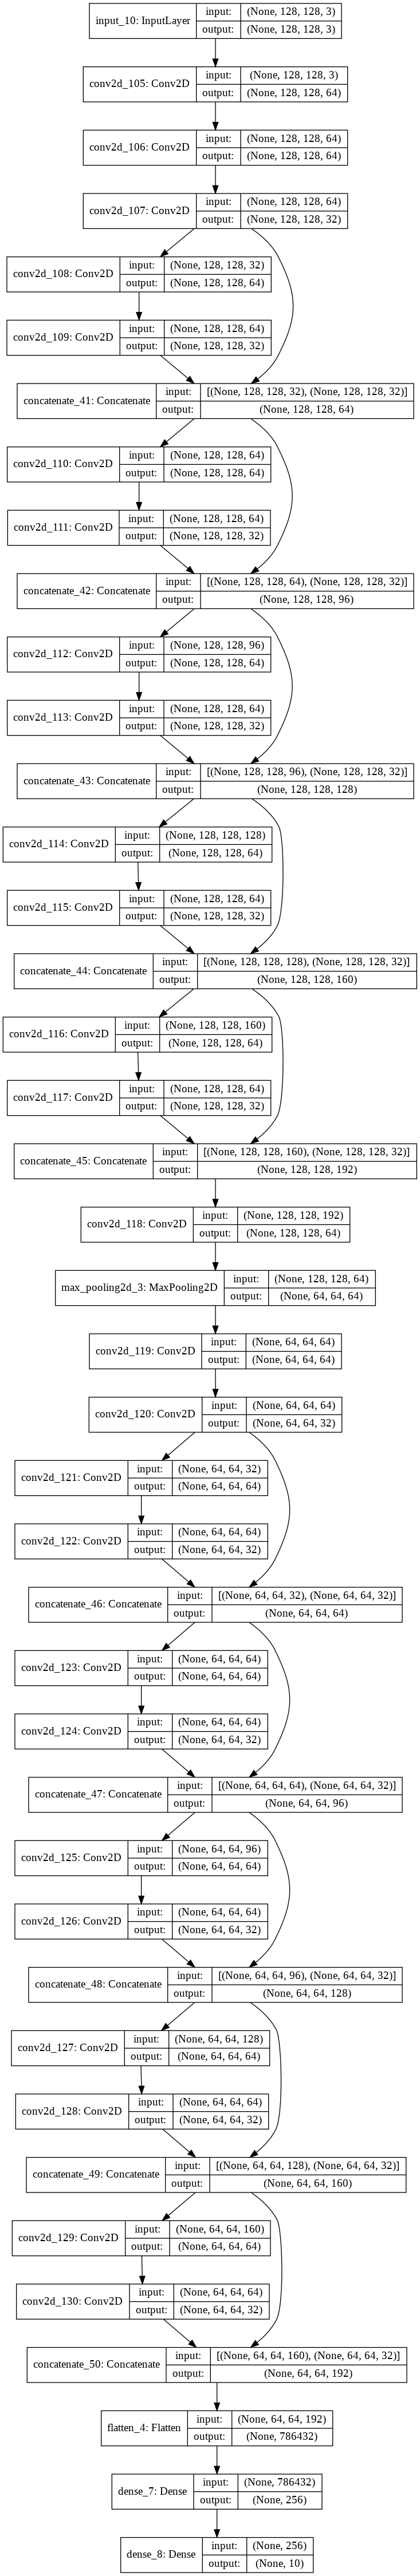

In [0]:
# Define input
inputs = Input(shape=(128, 128, 3))
# Initial convolution layer
conv = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)    
# Define first dense block
dense_block1 = condensed_dense_block(conv,6,32,64)
# Transition Block
tr_block = transition_block(dense_block1)
# Define second dense block
dense_block2 = condensed_dense_block(tr_block,6,32,64)
# Flatten for output
flat = Flatten()(dense_block2)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='dense_module.png')